# Detecting Forest Changes with FarmVibes.AI

This notebook demonstrates how to detect forest changes in ALOS PALSAR 2.1 Forest/Non-Forest maps using FarmVibes.AI. The reader can check [this notebook](./download_alos_forest_map.ipynb) to see how to download and visualize ALOS forest maps.

This notebook is divided into the following sections:

1. **Workflow setup**: It checks the workflow documentation using the FarmVibes.AI python client, and define the evaluation geometry and time range.
2. **Running the workflow**: The section shows how to execute the forest changes workflow and provide its parameters.
3. **Interpreting the results**. Finally, we will visualize and discuss the results.

## Micromamba environment setup
To install the required packages, see [this README file](../README.md). You can activate the environment with the following command:
```bash
$ micromamba activate farmvibes-ai
```

## 1. Workflow setup

In this Jupyter notebook, we are going to run the `forest_ai/deforestation/forest_change_detection` workflow in FarmVibes.AI, 
designed to analyze changes in forest coverage over a specific time range within a user-defined geographical area. 
The next cells will document the workflow using the FarmVibes.AI default client and define the user input (geometry + time-range).


In [1]:
from datetime import datetime
from typing import List, Optional, cast

import pandas as pd
from matplotlib import pyplot as plt
from shapely import geometry as shpg
from shapely.geometry import box

from vibe_core.client import get_default_vibe_client
from vibe_core.data import CategoricalRaster, Raster
from vibe_notebook.plot import plot_categorical_maps
from vibe_notebook.raster import read_raster

# Create the FarmVibes.AI default client
client = get_default_vibe_client()

WORKFLOW_NAME = "forest_ai/deforestation/alos_trend_detection"
client.document_workflow(WORKFLOW_NAME)

Workflow: forest_ai/deforestation/alos_trend_detection

Description:

Detects increase/decrease trends in forest pixel levels over the user-input geometry and time   
    range for the ALOS forest map. This workflow combines the alos_forest_extent_download_merge and 
    ordinal_trend_detection workflows to detect increase/decrease trends in the forest pixel levels 
    over the user-provided geometry and time range for the ALOS forest map. The ALOS PALSAR 2.1     
    Forest/Non-Forest Maps are downloaded in the alos_forest_extent_download_merge workflow.  Then  
    the ordinal_trend_detection workflow clips the ordinal raster to the user-provided geometry and 
    time range and determines if there is an increasing or decreasing trend in the forest pixel     
    levels over them. alos_trend_detection uses the Cochran-Armitage test to detect trends in the   
    forest levels over the years.  The null hypothesis is that there is no trend in the pixel levels
    over the list of rasters. The alternative hypothesis is that there is a trend in the forest     
    pixel levels over the list of rasters (one for each year). It returns a p-value and a z-score.  
    If the p-value is less than some significance level, the null hypothesis is rejected and the    
    alternative hypothesis is accepted. If the z-score is positive, the trend is increasing.  If the
    z-score is negative, the trend is decreasing.

Sources:

- user_input (vibe_core.data.core_types.DataVibe): Time range and geometry of interest.

Sinks:

- merged_raster (vibe_core.data.rasters.Raster): Merged raster of the ALOS PALSAR 2.1           
    Forest/Non-Forest Map for the user-provided geometry and time range.

- categorical_raster (vibe_core.data.rasters.CategoricalRaster): Categorical raster of the ALOS 
    PALSAR 2.1 Forest/Non-Forest Map for the user-provided geometry and time range before the merge 
    operation.

- recoded_raster (vibe_core.data.rasters.Raster): Recoded raster of the ALOS PALSAR 2.1         
    Forest/Non-Forest Map for the user-provided geometry and time range.

- clipped_raster (vibe_core.data.rasters.Raster): Clipped ordinal raster for the user-provided  
    geometry and time range.

- trend_test_result (vibe_core.data.core_types.OrdinalTrendTest): Cochran-armitage test results 
    composed of p-value and z-score.

Parameters:

- pc_key (default: None): Planetary Computer API key.

- from_values (default: task defined): Values to recode from.

- to_values (default: task defined): Values to recode to.

Tasks:

- alos_forest_extent_download_merge: Downloads Advanced Land Observing Satellite (ALOS)         
    forest/non-forest classification map and merges it into a single raster.

- ordinal_trend_detection: Detects increase/decrease trends in the pixel levels over the        
    user-input geometry and time range.

### Workflow discussion

The workflow tasks involve downloading Advanced Land Observing Satellite (ALOS) forest/non-forest classification maps and merging them into a single raster (`alos_forest_extent_download_merge`). The ALOS products are clipped to the user's geometry (`clip`), and the result is used to calculate the cochran-armitage trend test (`trend_rest_result`). This test checks if there has been a statistically significant trend in the forest distribution over time.

The `user_input` is composed of a geometry and a time-range, which will be defined in the next cell.

As output (`sinks`), the workflow provides a list of merged rasters (`merged_raster`) that encompass the user input geometry for each year defined in the time-range, the products are available in the [Planetary Computer dataset](https://planetarycomputer.microsoft.com/dataset/alos-fnf-mosaic).
It also produces a list of categorical rasters (`categorical_raster`) that intersect with the user-provided geometry and time range. The distinction between `categorical_raster` and `merged_raster` is that multiple `categorical_raster` tiles can be combined to form the `merged_raster` if the user's geometry intersects with more than one forest tile. The `recoded_raster` contains the rasters with the recoded values for the forest maps. Finally, `trend_rest_result` determines whether the pixel distribution has changed over time. This is useful for determining if there is statistical evidence of trend in the forest area over time. This change could represent either an increase or decrease in the frequency of forest pixels (i.e., only changes are detected).

The workflow parameters are the Planetary Computer API key (`pc_key`) and the recode rasters parameters that are used to map the values from the dataset raster to the recoded raster. For example, if the original raster has values `(2, 1, 3, 4, 5)` and assuming the default values of `from_values` and `to_values`  are respectively `[1, 2, 3, 4, 5]`  and `[6, 7, 8, 9, 10`], the recoded raster  will have values `(7, 6, 8, 9, 10)`.




In [2]:
geo_json = {
    "type": "Feature",
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [-86.783827, 14.565498],
                [-86.780459, 14.569303],
                [-86.774283, 14.565106],
                [-86.779591, 14.557595],
                [-86.783827, 14.565498],
            ]
        ],
    },
    "properties": {},
}


geom = shpg.shape(geo_json["geometry"])
time_range = (datetime(2017, 1, 1), datetime(2020, 12, 31))

## 2. Running the Workflow

Observe that we pass the geometry and time-range as workflow inputs, along with the following parameters:

* `pc_key`: This corresponds to the Planetary Computer API key, which is useful for downloading planetary computer imagery.
* `from_values`: Values to recode from, for the ALOS dataset the default value is `[4, 3, 0, 2, 1]`.
* `to_values`: Values to recode to, `[0, 0, 0, 1, 1]` are the default values for the ALOS dataset.


For this particular case, we are mapping the forest values from [ALOS dataset](https://planetarycomputer.microsoft.com/dataset/alos-fnf-mosaic) to `1` and `2` depending on the canopy cover level and everything else to `0`.

| Encoded Value | Description | Recoded Value (Forest-Level) | Recoded Value Semantics |
| ------------- | ----------- | ----------- | --------------|
| 0 | No data | 0 | Non-Forest |
| 1 | Forest (>90% canopy cover) | 2 | Dense-Forest |
| 2 | Forest (10-90% canopy cover) | 1 | Forest |
| 3 | Non-forest | 0 | Non-Forest |
| 4 | Water | 0 | Non-Forest |

Please check the [workflow documentation page](https://microsoft.github.io/farmvibes-ai/docfiles/markdown/WORKFLOWS.html) to see how parameters are provided. Also, refer to the [SECRETS documentation](https://microsoft.github.io/farmvibes-ai/docfiles/markdown/SECRETS.html) to learn how a secret can be added to the FarmVibes.AI cluster.


In [3]:
# Execute the workflow
run = client.run(
    WORKFLOW_NAME,
    "Forest Change Detection",
    geometry=geom,
    time_range=time_range,
    parameters={
        "pc_key": "@SECRET(eywa-secrets, pc-sub-key)",
        "from_values": [4, 3, 0, 2, 1],
        "to_values": [0, 0, 0, 1, 2],
    },
)
run.monitor()

Output()

## 3. Interpreting the results

The `trend_rest_result` is an output from the workflow run, which performs a trend test (Cochan-Armitage). The result of this test includes a `csv` file containing a contingency table, which shows the distribution of pixel counts across the different categories of land cover for each year. This allows us to observe how the distribution of pixel categories has changed over time.

In [4]:
trend_test_test_results = run.output["trend_test_result"][0]  # type: ignore
df = pd.read_csv(trend_test_test_results.assets[0].path_or_url, index_col=0)  # type: ignore


level_names = ["Non-Forest", "Forest", "Dense-forest"]
index = dict(zip(df.index, level_names))
df.index = df.index.map(index)
df

,2017/01/01-2017/12/31,2018/01/01-2018/12/31,2019/01/01-2019/12/31,2020/01/01-2020/12/31
category,,,,
Non-Forest,178.0,49.0,107.0,69.0
Forest,675.0,628.0,553.0,363.0
Dense-forest,273.0,449.0,466.0,694.0


### Read the output data

In the next cell, we adopt the user-provided geometry to read the output raster and create some buffer around it.

In [5]:
# Define your geometry
bounding_box = box(*geom.buffer(0.01).bounds)

# Get the bounds of the geometry
minx, miny, maxx, maxy = bounding_box.bounds

merged_rasters = run.output["merged_raster"]
categories = cast(CategoricalRaster, run.output["categorical_raster"][0]).categories
forest_images = []

for raster in merged_rasters:
    merged_raster = cast(Raster, raster)
    forest_images.append(read_raster(merged_raster, bounding_box)[0][0])

### Plot the result map

Finally, we plot the raster images with the existing categories and the user-provided geometry (red area within the plot).

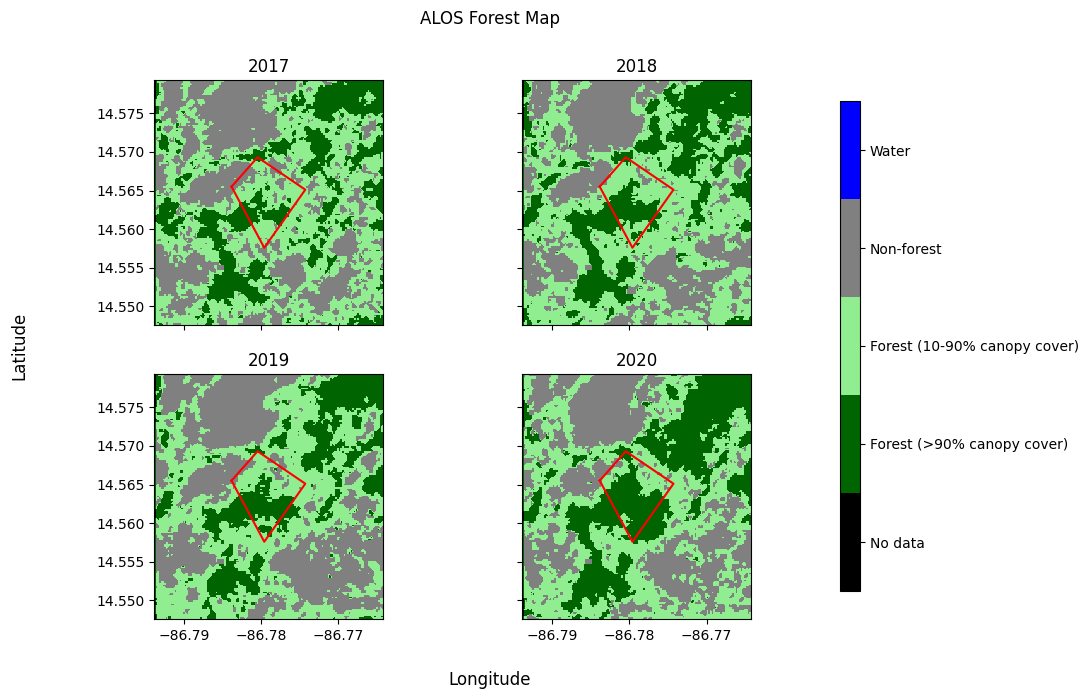

In [6]:
color_dict = {
    0: "black",
    1: "darkgreen",
    2: "lightgreen",
    3: "gray",
    4: "blue",
}

titles = [str(raster.time_range[0].year) for raster in run.output["merged_raster"]]

plot_categorical_maps(
    forest_images,
    color_dict,
    categories,
    titles=titles,
    suptitle="ALOS Forest Map",
    geom_exterior=geom.exterior.xy,
    extent=[minx, maxx, miny, maxy],
    figsize=(10, 7),
    xlabel="Longitude",
    ylabel="Latitude",
)

### Read the ordinal raster data

In [7]:
recoded_rasters = run.output["recoded_raster"]
forest_images = []

for raster in recoded_rasters:
    ordinal_raster = cast(Raster, raster)
    forest_images.append(read_raster(ordinal_raster, bounding_box)[0][0])

#### Present the results using plot

Although we've observed a change in the frequency of forest pixels over the years, we can use statistical testing to determine whether there is a significant trend in the forest change or it is simply the result of random fluctuations in the data. 

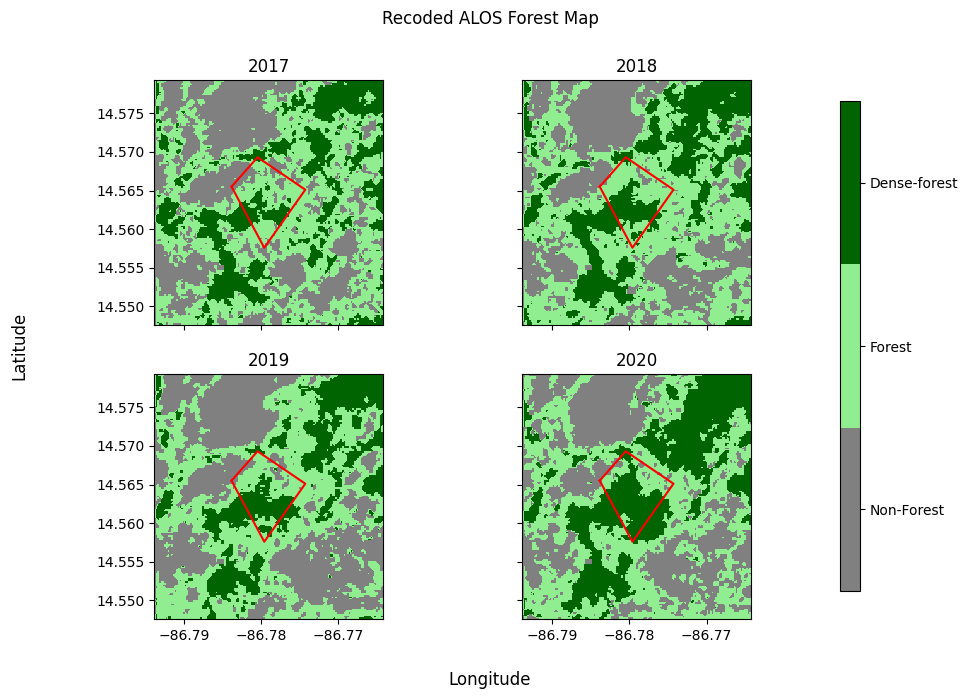

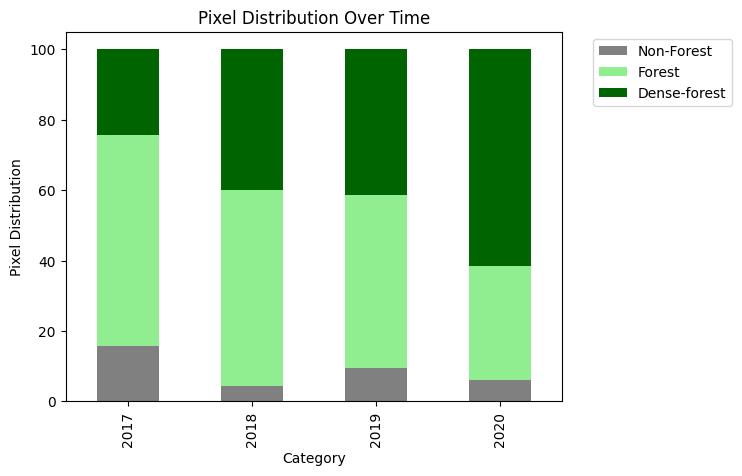

In [8]:
def plot_pixel_distribution(
    df: pd.DataFrame,
    highlight_column: Optional[int] = None,
    ax: Optional[plt.Axes] = None,
    use_legend: bool = True,
    colors: Optional[List["str"]] = None,
    title: Optional[str] = "Pixel Distribution Over Time",
):
    filtered_df = df.copy()
    # Extract the year from the column names
    filtered_df.columns = [label[:4] for label in filtered_df.columns]
    # Transpose the DataFrame
    df_transposed = filtered_df.transpose()

    # Normalize the data so that the pixel counts sum to 100% for each year
    df_normalized = df_transposed.div(df_transposed.sum(axis=1), axis=0) * 100

    if colors:
        ax = df_normalized.plot(kind="bar", stacked=True, ax=ax, color=colors)
    else:
        ax = df_normalized.plot(kind="bar", stacked=True, ax=ax)

    # Highlight the specified column by setting its alpha to 1
    if highlight_column is not None:
        # Apply alpha to all bars
        for container in ax.containers:
            for bar in container:
                bar.set_alpha(0.3)

        for container in ax.containers:
            container[highlight_column].set_alpha(1)

    ax.set_title(title)
    ax.set_ylabel("Pixel Distribution")
    ax.set_xlabel("Category")

    # Add a legend outside of the plot
    if use_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        ax.get_legend().remove()

    return df_normalized


color_dict = {
    0: "grey",
    1: "lightgreen",
    2: "darkgreen",
}

titles = [str(raster.time_range[0].year) for raster in recoded_rasters]

# We plot the categorical raster pixel distribution again for
# better visualization of the pixel distribution over time
plot_categorical_maps(
    forest_images,
    color_dict,
    level_names,
    titles=titles,
    suptitle="Recoded ALOS Forest Map",
    geom_exterior=geom.exterior.xy,
    extent=[minx, maxx, miny, maxy],
    figsize=(10, 7),
    xlabel="Longitude",
    ylabel="Latitude",
)

# Filter out the "no data" category
filtered_df = df
colors = [color_dict[level_names.index(cat)] for cat in filtered_df.index]
# get the corresponding colors
_ = plot_pixel_distribution(filtered_df, use_legend=True, colors=colors)

### Conclusion

Finally, we employed the Cochan-Armitage trend test. This test is specifically designed to determine if there is an increasing/decreasing trend between the two categorical variables. In our case, the two variables are 'forest/non-forest pixels distribution' and 'year'. By applying the trend test, we can quantitatively assess whether the changes we've observed in pixel categories over time are statistically significant, or if they could be attributed to random variation.

The conclusion of this test is printed in the next cell.

In [9]:
SIGNIFICANCE_LEVEL = 0.05

print("******* COCHAN-ARMITAGE TREND TEST RESULTS *******")
print(f"p-value {trend_test_test_results.p_value}")
print(f"significance level {SIGNIFICANCE_LEVEL}")
print(f"z_score {trend_test_test_results.z_score}")

print("******* CONCLUSION *******")
if trend_test_test_results.p_value < SIGNIFICANCE_LEVEL:
    print("The null hypothesis is rejected.")

    if trend_test_test_results.z_score > 0:
        print(
            "The categorical rasters are positively dependent, so the level of forest cover is increasing."
        )
    else:
        print(
            "The categorical rasters are negatively dependent, so the level of forest cover is decreasing."
        )

else:
    print("The null hypothesis is not rejected. The categorical rasters are independent.")

******* COCHAN-ARMITAGE TREND TEST RESULTS *******
p-value 6.127822361209561e-60
significance level 0.05
z_score 16.329103461498548
******* CONCLUSION *******
The null hypothesis is rejected.
The categorical rasters are positively dependent, so the level of forest cover is increasing.
